In [2]:
import pandas as pd
import sqlite3
import zipfile
import os

zip_file_path = r'C:\Data\archive.zip' 
extract_to = r'C:\Data\olist_extracted' 
db_path = r'C:\Data\olist_ecommerce.db'

# 1. Tạo thư mục giải nén 
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

try:
    # 2. Giải nén
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print("--- Giải nén thành công vào C:\Data\olist_extracted ---")

    # 3. Kết nối SQL và nạp dữ liệu
    conn = sqlite3.connect(db_path)
    
    for file_name in os.listdir(extract_to):
        if file_name.endswith('.csv'):
            table_name = file_name.replace('.csv', '').replace('_dataset', '')
            df = pd.read_csv(os.path.join(extract_to, file_name))
            
            # Nạp vào SQL
            df.to_sql(table_name, conn, if_exists='replace', index=False)
            print(f"Đã nạp bảng: {table_name}")
            
    conn.close()
    print(f"\n--- Xong! Database của bạn đã sẵn sàng tại: {db_path} ---")

except PermissionError:
    print("LỖI QUYỀN TRUY CẬP: Bạn hãy chuột phải vào VS Code/Jupyter và chọn 'Run as Administrator'.")
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\3323765200.py:18: SyntaxWarning: invalid escape sequence '\D'
  print("--- Giải nén thành công vào C:\Data\olist_extracted ---")


--- Giải nén thành công vào C:\Data\olist_extracted ---
Đã nạp bảng: olist_customers
Đã nạp bảng: olist_geolocation
Đã nạp bảng: olist_orders
Đã nạp bảng: olist_order_items
Đã nạp bảng: olist_order_payments
Đã nạp bảng: olist_order_reviews
Đã nạp bảng: olist_products
Đã nạp bảng: olist_sellers
Đã nạp bảng: product_category_name_translation

--- Xong! Database của bạn đã sẵn sàng tại: C:\Data\olist_ecommerce.db ---


In [3]:
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

# Lưu ý: Đổi 'orders' thành 'olist_orders'
query_check_null = """
SELECT 
    COUNT(*) AS total_orders,
    SUM(CASE WHEN order_delivered_customer_date IS NULL THEN 1 ELSE 0 END) AS missing_delivery_date,
    SUM(CASE WHEN order_status = 'canceled' THEN 1 ELSE 0 END) AS canceled_orders
FROM olist_orders;
"""

try:
    check_df = pd.read_sql_query(query_check_null, conn)
    print("--- Kết quả kiểm tra dữ liệu ---")
    print(check_df)
except Exception as e:
    print(f"Vẫn có lỗi: {e}")

conn.close()

--- Kết quả kiểm tra dữ liệu ---
   total_orders  missing_delivery_date  canceled_orders
0         99441                   2965              625


In [4]:
import matplotlib.pyplot as plt

# 1. Kết nối database
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

# 2. Viết câu lệnh SQL (Bài toán 1)
query_monthly_revenue = """
SELECT 
    strftime('%Y-%m', o.order_purchase_timestamp) AS month,
    ROUND(SUM(oi.price), 2) AS total_revenue,
    COUNT(DISTINCT o.order_id) AS total_orders
FROM olist_orders o
JOIN olist_order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY month
ORDER BY month;
"""

# 3. Thực thi và lưu vào DataFrame
df_monthly = pd.read_sql_query(query_monthly_revenue, conn)

# 4. Hiển thị kết quả
print("--- Thống kê doanh thu theo tháng ---")
print(df_monthly)

conn.close()

--- Thống kê doanh thu theo tháng ---
      month  total_revenue  total_orders
0   2016-09         134.97             1
1   2016-10       40325.11           265
2   2016-12          10.90             1
3   2017-01      111798.36           750
4   2017-02      234223.40          1653
5   2017-03      359198.85          2546
6   2017-04      340669.68          2303
7   2017-05      489338.25          3546
8   2017-06      421923.37          3135
9   2017-07      481604.52          3872
10  2017-08      554699.70          4193
11  2017-09      607399.67          4150
12  2017-10      648247.65          4478
13  2017-11      987765.37          7289
14  2017-12      726033.19          5513
15  2018-01      924645.00          7069
16  2018-02      826437.13          6555
17  2018-03      953356.25          7003
18  2018-04      973534.09          6798
19  2018-05      977544.69          6749
20  2018-06      856077.86          6099
21  2018-07      867953.46          6159
22  2018-08      83

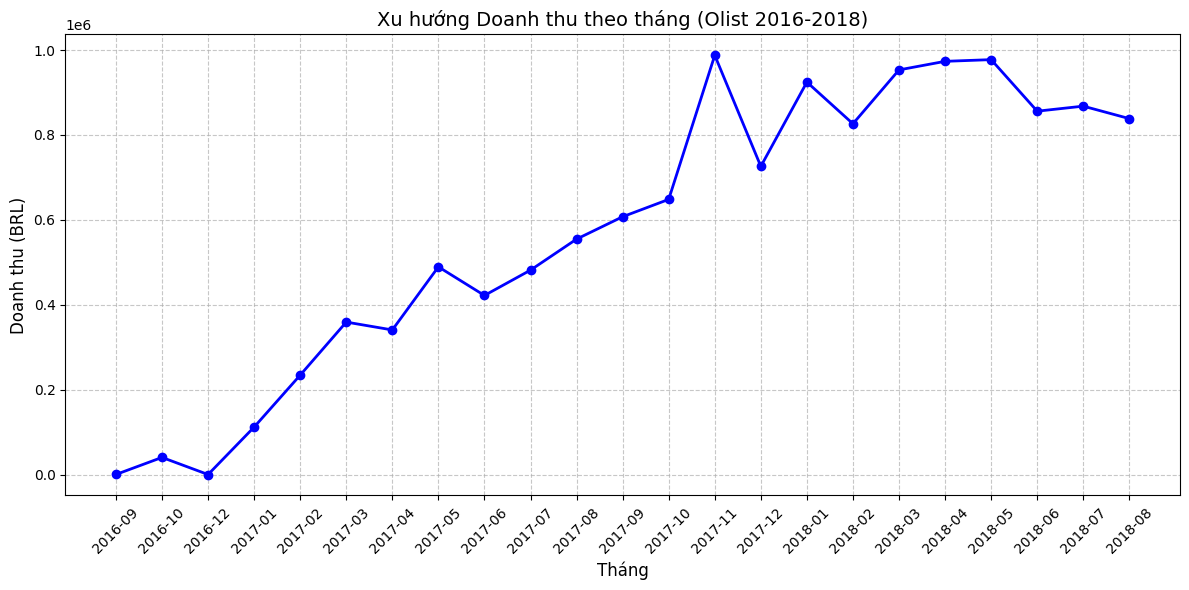

In [5]:
# Thiết lập kích thước biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ đường doanh thu (Line plot)
plt.plot(df_monthly['month'], df_monthly['total_revenue'], marker='o', color='b', linestyle='-', linewidth=2)

# Thêm tiêu đề và nhãn
plt.title('Xu hướng Doanh thu theo tháng (Olist 2016-2018)', fontsize=14)
plt.xlabel('Tháng', fontsize=12)
plt.ylabel('Doanh thu (BRL)', fontsize=12)

# Xoay nhãn trục X để dễ đọc hơn
plt.xticks(rotation=45)

# Thêm lưới (grid) để dễ quan sát con số
plt.grid(True, linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [6]:
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

# Truy vấn chi tiết đơn hàng của các tháng bị thấp
query_detective = """
SELECT 
    order_id, 
    customer_id, 
    order_status, 
    order_purchase_timestamp,
    order_delivered_customer_date
FROM olist_orders
WHERE strftime('%Y-%m', order_purchase_timestamp) IN ('2016-09', '2016-12');
"""

detective_df = pd.read_sql_query(query_detective, conn)
print("--- Chi tiết 2 đơn hàng bất thường ---")
print(detective_df)

conn.close()

--- Chi tiết 2 đơn hàng bất thường ---
                           order_id                       customer_id  \
0  e5fa5a7210941f7d56d0208e4e071d35  683c54fc24d40ee9f8a6fc179fd9856c   
1  2e7a8482f6fb09756ca50c10d7bfc047  08c5351a6aca1c1589a38f244edeee9d   
2  809a282bbd5dbcabb6f2f724fca862ec  622e13439d6b5a0b486c435618b2679e   
3  bfbd0f9bdef84302105ad712db648a6c  86dc2ffce2dfff336de2f386a786e574   
4  bd50a7fe9fd97ea4b7663031a319e150  0975c3cf2e418ebfa5d1191a2dffd59d   

  order_status order_purchase_timestamp order_delivered_customer_date  
0     canceled      2016-09-05 00:15:34                          None  
1      shipped      2016-09-04 21:15:19                          None  
2     canceled      2016-09-13 15:24:19                          None  
3    delivered      2016-09-15 12:16:38           2016-11-09 07:47:38  
4    delivered      2016-12-23 23:16:47           2016-12-28 15:54:44  


In [7]:
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

# Câu lệnh SQL lọc bỏ năm 2016 và tính doanh thu
query_clean = """
SELECT 
    strftime('%Y-%m', o.order_purchase_timestamp) AS month,
    ROUND(SUM(oi.price), 2) AS revenue
FROM olist_orders o
JOIN olist_order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered' 
  AND o.order_purchase_timestamp >= '2017-01-01'
GROUP BY month
ORDER BY month;
"""

df_clean = pd.read_sql_query(query_clean, conn)

# Dùng Python để tính % tăng trưởng so với tháng trước (MoM)
df_clean['mom_growth'] = df_clean['revenue'].pct_change() * 100

print("--- Dữ liệu tăng trưởng sạch (2017-2018) ---")
print(df_clean.head(10))

--- Dữ liệu tăng trưởng sạch (2017-2018) ---
     month    revenue  mom_growth
0  2017-01  111798.36         NaN
1  2017-02  234223.40  109.505220
2  2017-03  359198.85   53.357372
3  2017-04  340669.68   -5.158471
4  2017-05  489338.25   43.640094
5  2017-06  421923.37  -13.776744
6  2017-07  481604.52   14.145021
7  2017-08  554699.70   15.177428
8  2017-09  607399.67    9.500631
9  2017-10  648247.65    6.725058


C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\2809990219.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_clean['month'], rotation=45)


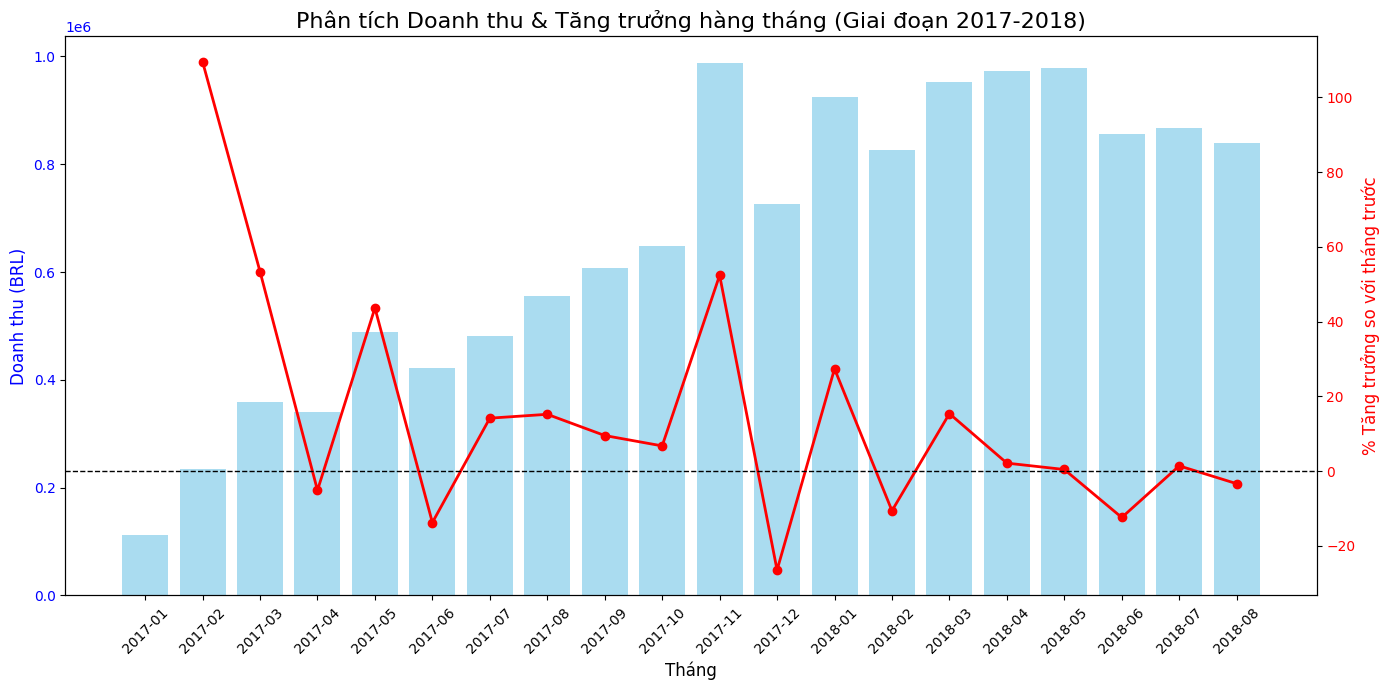

In [8]:
# Tạo khung hình và trục thứ nhất (cho Doanh thu)
fig, ax1 = plt.subplots(figsize=(14, 7))

# Vẽ biểu đồ cột cho Doanh thu
ax1.bar(df_clean['month'], df_clean['revenue'], color='skyblue', alpha=0.7, label='Doanh thu (BRL)')
ax1.set_xlabel('Tháng', fontsize=12)
ax1.set_ylabel('Doanh thu (BRL)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(df_clean['month'], rotation=45)

# Tạo trục thứ hai dùng chung trục X (cho % Tăng trưởng)
ax2 = ax1.twinx()
ax2.plot(df_clean['month'], df_clean['mom_growth'], color='red', marker='o', linewidth=2, label='% Tăng trưởng MoM')
ax2.set_ylabel('% Tăng trưởng so với tháng trước', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Thêm đường kẻ ngang ở mức 0% để dễ quan sát
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

# Tiêu đề và chú thích
plt.title('Phân tích Doanh thu & Tăng trưởng hàng tháng (Giai đoạn 2017-2018)', fontsize=16)
fig.tight_layout()
plt.show()

In [9]:
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

# SQL: Tính doanh thu theo Bang
query_geo = """
SELECT 
    c.customer_state,
    ROUND(SUM(oi.price), 2) AS total_revenue
FROM olist_orders o
JOIN olist_order_items oi ON o.order_id = oi.order_id
JOIN olist_customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY total_revenue DESC;
"""

df_geo = pd.read_sql_query(query_geo, conn)

# Tính % đóng góp của từng bang
total_all_revenue = df_geo['total_revenue'].sum()
df_geo['percentage'] = (df_geo['total_revenue'] / total_all_revenue) * 100

print("--- Top 5 Bang đóng góp doanh thu lớn nhất ---")
print(df_geo.head(5))
conn.close()

--- Top 5 Bang đóng góp doanh thu lớn nhất ---
  customer_state  total_revenue  percentage
0             SP     5067633.16   38.328736
1             RJ     1759651.13   13.309015
2             MG     1552481.83   11.742102
3             RS      728897.47    5.512972
4             PR      666063.51    5.037731


In [10]:
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

# SQL: Tính số ngày giao hàng trung bình theo từng Bang
query_shipping = """
SELECT 
    c.customer_state,
    ROUND(AVG(julianday(o.order_delivered_customer_date) - julianday(o.order_purchase_timestamp)), 1) AS avg_delivery_days
FROM olist_orders o
JOIN olist_customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered' 
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state
ORDER BY avg_delivery_days ASC;
"""

df_shipping = pd.read_sql_query(query_shipping, conn)

print("--- Hiệu suất giao hàng theo Bang (Từ nhanh nhất đến chậm nhất) ---")
print(df_shipping)
conn.close()

--- Hiệu suất giao hàng theo Bang (Từ nhanh nhất đến chậm nhất) ---
   customer_state  avg_delivery_days
0              SP                8.8
1              MG               12.0
2              PR               12.0
3              DF               13.0
4              SC               15.0
5              RJ               15.3
6              RS               15.3
7              GO               15.6
8              MS               15.6
9              ES               15.8
10             TO               17.7
11             MT               18.1
12             PE               18.4
13             BA               19.3
14             RN               19.3
15             RO               19.4
16             PI               19.5
17             PB               20.4
18             AC               21.0
19             CE               21.3
20             SE               21.5
21             MA               21.6
22             PA               23.8
23             AL               24.5
24     

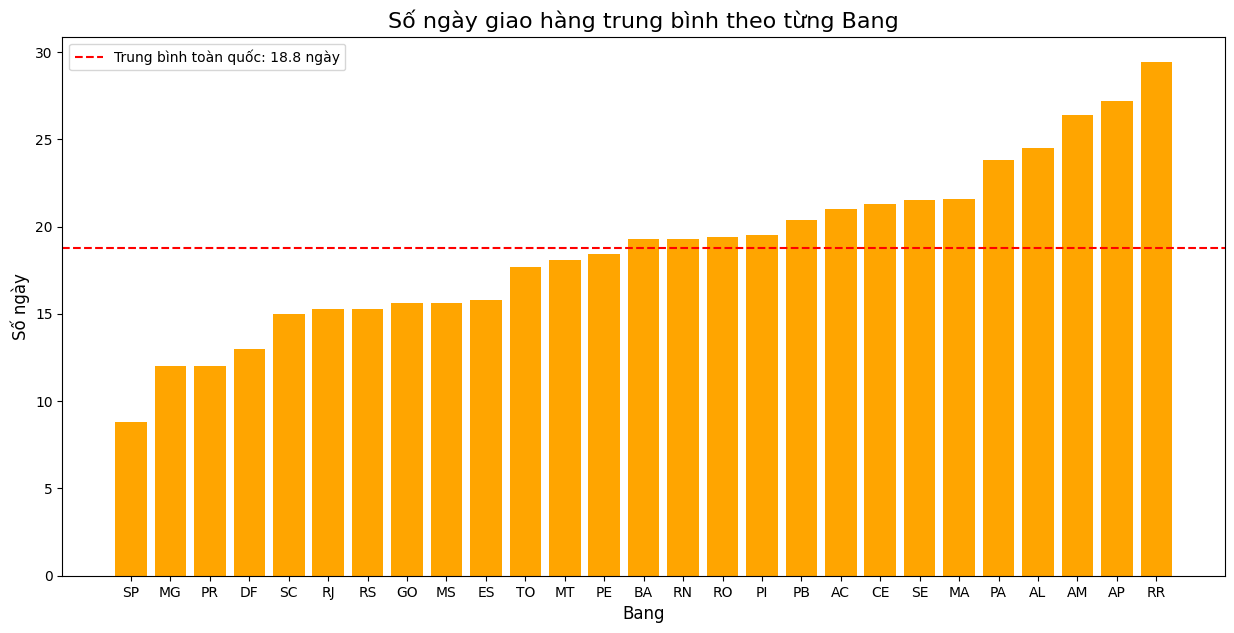

In [11]:
plt.figure(figsize=(15, 7))
bars = plt.bar(df_shipping['customer_state'], df_shipping['avg_delivery_days'], color='orange')

# Thêm đường trung bình toàn hệ thống để so sánh
avg_all = df_shipping['avg_delivery_days'].mean()
plt.axhline(avg_all, color='red', linestyle='--', label=f'Trung bình toàn quốc: {avg_all:.1f} ngày')

plt.title('Số ngày giao hàng trung bình theo từng Bang', fontsize=16)
plt.xlabel('Bang', fontsize=12)
plt.ylabel('Số ngày', fontsize=12)
plt.legend()
plt.show()

In [12]:
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')

query_rfm = """
SELECT 
    c.customer_unique_id,
    o.order_id,
    o.order_purchase_timestamp,
    oi.price
FROM olist_orders o
JOIN olist_order_items oi ON o.order_id = oi.order_id
JOIN olist_customers c ON o.customer_id = c.customer_id
WHERE o.order_status = 'delivered';
"""
df = pd.read_sql_query(query_rfm, conn)
conn.close()

# 2. Xử lý thời gian
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Giả định ngày phân tích là 1 ngày sau ngày mua cuối cùng trong dữ liệu
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# 3. Tính toán R, F, M cho mỗi khách hàng
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days, # Recency
    'order_id': 'nunique',                                             # Frequency
    'price': 'sum'                                                     # Monetary
})

# Đổi tên cột
rfm.columns = ['Recency', 'Frequency', 'Monetary']

print("--- 5 dòng đầu của bảng RFM thô ---")
print(rfm.head())

--- 5 dòng đầu của bảng RFM thô ---
                                  Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      112          1    129.90
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     18.90
0000f46a3911fa3c0805444483337064      537          1     69.00
0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99
0004aac84e0df4da2b147fca70cf8255      288          1    180.00


In [13]:
# Đánh điểm từ 1-5 (5 là tốt nhất)
# Recency: Càng nhỏ càng tốt nên dùng labels ngược [5, 4, 3, 2, 1]
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency & Monetary: Càng lớn càng tốt [1, 2, 3, 4, 5]
# Lưu ý: Với Olist, đa số khách chỉ mua 1 lần nên F_Score có thể bị trùng lặp, ta xử lý bằng rank
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Tính tổng điểm RFM
rfm['RFM_Group'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# 4. Định nghĩa phân khúc khách hàng
def segment_customer(df):
    score = df['RFM_Score']
    if score >= 13:
        return 'Champions (VIP)'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print("\n--- Kết quả phân nhóm khách hàng ---")
print(rfm['Segment'].value_counts())


--- Kết quả phân nhóm khách hàng ---
Segment
At Risk            38521
Loyal Customers    31260
Lost Customers     15683
Champions (VIP)     7894
Name: count, dtype: int64


In [14]:
output_path = r'C:\Data\Olist_Final_Analysis.xlsx'

# Sử dụng ExcelWriter để ghi nhiều sheet
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    # 1. Sheet Doanh thu tháng (Bài toán 1)
    df_clean.to_excel(writer, sheet_name='Monthly_Revenue', index=False)
    
    # 2. Sheet Địa lý (Bài toán 2)
    df_geo.to_excel(writer, sheet_name='Geographical_Analysis', index=False)
    
    # 3. Sheet Vận chuyển (Bài toán 3)
    df_shipping.to_excel(writer, sheet_name='Shipping_Performance', index=False)
    
    # 4. Sheet Phân khúc RFM (Bài toán nâng cao)
    rfm.to_excel(writer, sheet_name='RFM_Segmentation', index=True)

print(f"--- THÀNH CÔNG! ---")
print(f"File của bạn đã sẵn sàng tại: {output_path}")

--- THÀNH CÔNG! ---
File của bạn đã sẵn sàng tại: C:\Data\Olist_Final_Analysis.xlsx


In [24]:
from mlxtend.frequent_patterns import apriori, association_rules

# Kết nối lại SQL để lấy thông tin sản phẩm (nếu chưa có)
conn = sqlite3.connect(r'C:\Data\olist_ecommerce.db')
df_items = pd.read_sql("SELECT order_id, product_id FROM olist_order_items", conn)
df_prod_name = pd.read_sql("SELECT product_id, product_category_name FROM olist_products", conn)
conn.close()

df_order_details = pd.merge(df_items, df_prod_name, on='product_id')

rfm_reset = rfm.reset_index()

customer_order_map = df[['customer_unique_id', 'order_id']].drop_duplicates()
df_final = pd.merge(df_order_details, customer_order_map, on='order_id')
df_final = pd.merge(df_final, rfm_reset[['customer_unique_id', 'Segment']], on='customer_unique_id')

print("--- Chuẩn bị dữ liệu thành công ---")

--- Chuẩn bị dữ liệu thành công ---


In [30]:
def get_recommendations_by_segment(segment_name, min_support=0.01):
    # 1. Lọc dữ liệu theo phân khúc
    segment_df = df_final[df_final['Segment'] == segment_name]
    
    # 2. Tạo ma trận giỏ hàng (Basket Matrix)
    basket = (segment_df.groupby(['order_id', 'product_category_name'])['product_id']
              .count().unstack().reset_index().fillna(0)
              .set_index('order_id'))
    
    # 3. Mã hóa sang kiểu Boolean (Sửa cả 2 cảnh báo tại đây)
    basket_sets = basket.map(lambda x: x >= 1).astype(bool)
    
    # Loại bỏ đơn hàng chỉ có 1 sản phẩm
    basket_sets = basket_sets[(basket_sets.sum(axis=1) > 1)]
    
    if basket_sets.empty:
        return f"Không đủ dữ liệu cặp sản phẩm cho nhóm {segment_name}"

    # 4. Chạy thuật toán Apriori
    frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)
    # 5. Tạo luật kết hợp
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    return rules.sort_values('lift', ascending=False)

In [31]:
champions_rules = get_recommendations_by_segment('Champions (VIP)')
at_risk_rules = get_recommendations_by_segment('At Risk')
loyal_rules = get_recommendations_by_segment('Loyal Customers')

print("Top 10 cặp sản phẩm gợi ý cho nhóm At Risk:")
display(at_risk_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Top 10 cặp sản phẩm gợi ý cho nhóm At Risk:


,antecedents,consequents,support,confidence,lift
33,(market_place),(livros_interesse_geral),0.010050,0.500000,24.875000
32,(livros_interesse_geral),(market_place),0.010050,0.500000,24.875000
0,(audio),(relogios_presentes),0.015075,1.000000,16.583333
1,(relogios_presentes),(audio),0.015075,0.250000,16.583333
34,(malas_acessorios),(papelaria),0.010050,0.666667,9.476190
35,(papelaria),(malas_acessorios),0.010050,0.142857,9.476190
12,(beleza_saude),(perfumaria),0.015075,0.187500,5.330357
13,(perfumaria),(beleza_saude),0.015075,0.428571,5.330357
2,(automotivo),(telefonia),0.010050,0.222222,4.020202
3,(telefonia),(automotivo),0.010050,0.181818,4.020202


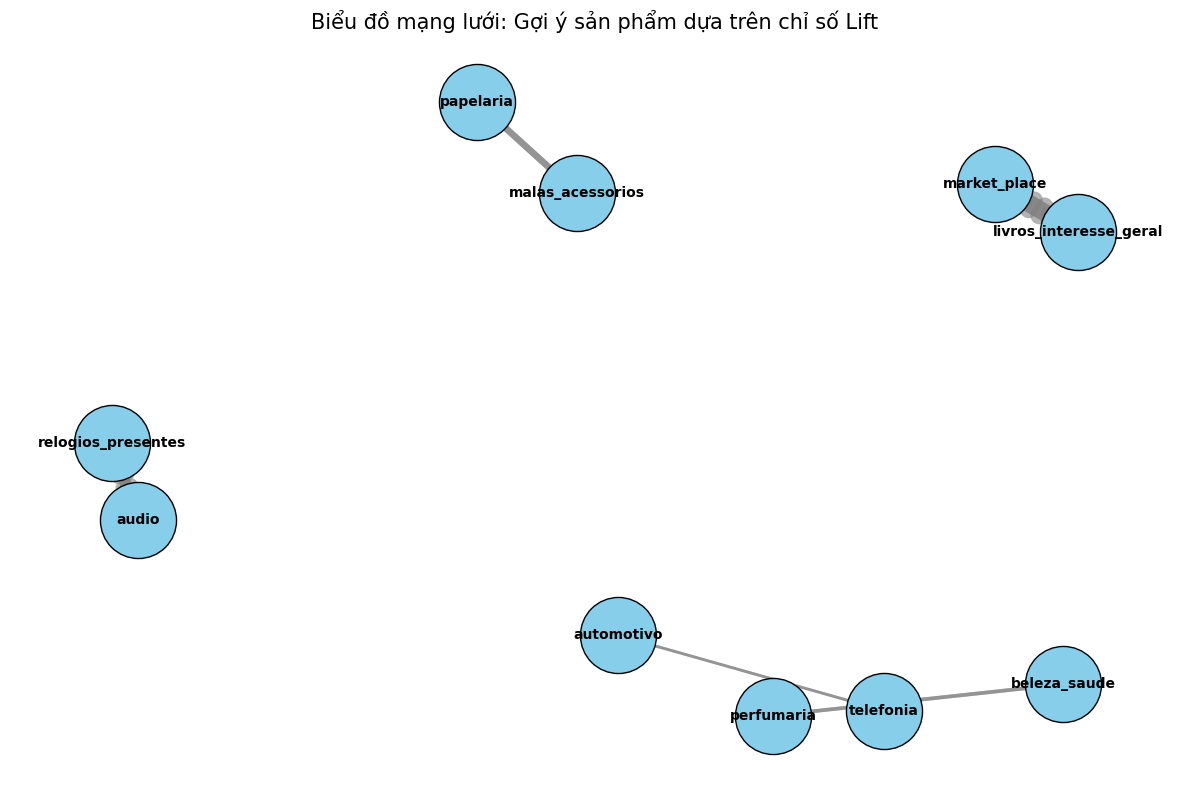

In [32]:
rules = at_risk_rules.copy()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

G = nx.DiGraph()
for idx, row in rules.head(10).iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

pos = nx.spring_layout(G, k=1.5, seed=42) 

plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', edgecolors='black')

edges = G.edges(data=True)
weights = [d['weight'] / 2 for (u, v, d) in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', alpha=0.6, arrowsize=20)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Biểu đồ mạng lưới: Gợi ý sản phẩm dựa trên chỉ số Lift", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()